# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams

## General parameters

In [5]:
n_iter_fs = 1
n_iter = 1
contamination_percentage = [0.8] 
trees = [25, 50, 100]

## Arrhythmia

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [6]:
dataset_id = 'arrhythmia'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(452, 275)

In [7]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,386
1,66


In [8]:
excluded_cols = ['Col15', 'Col63', 'Col65', 'Col79', 'Col127', 'Col128','Col135', 'Col137', 'Col139','Col141','Col147', 'Col152', 'Col153', 'Col160', 'Col200', 'Col260', 'Col270']

### iForest

## Parameters

In [22]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)
df.head()

,n_estimators,contamination,n_feats,n_iter,n_iter_fs,roc_auc,iforest_stab_unif_median,shap_iforest_stab_unif_median,f1_median,recall_median,precision_median,confusion_matrix,shap_q1,shap_q2,shap_q3
0,25,0.117,8,1,1,0.621251,0.917350,"[0.9999999999999805, 0.9999999999999848, 0.999...",0.151261,0.136364,0.169811,1,1.000000,1.000000,1.000000
1,25,0.117,18,1,1,0.717028,0.916932,"[0.9999999986817016, 0.999999999296087, 0.9999...",0.369748,0.333333,0.415094,1,1.000000,1.000000,1.000000
2,25,0.117,29,1,1,0.713103,0.911153,"[0.9999996226681006, 0.9999993368368496, 0.999...",0.319328,0.287879,0.358491,1,1.000000,1.000000,1.000000
3,25,0.117,42,1,1,0.715693,0.872751,"[0.9999150228441998, 0.9998825200050224, 0.999...",0.436975,0.393939,0.490566,1,0.999955,0.999943,0.999924
4,25,0.117,57,1,1,0.713338,0.863626,"[0.9958795401265791, 0.9952391376168573, 0.997...",0.352941,0.318182,0.396226,1,0.997155,0.996312,0.995609


## Visualization of the results

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

# if we want to create an iteractive plot or not
%matplotlib widget

In [36]:
def plot_3d_surface(df, x_label, y_label, z_label, cmap='viridis', y_step=10):
    """
    Generates a 3D surface plot for the specified columns in a pandas DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - x_label: The name of the column to be used as the X-axis.
    - y_label: The name of the column to be used as the Y-axis.
    - z_label: The name of the column to be used as the Z-axis.
    - cmap: The colormap for the surface. Defaults to 'viridis'.
    - y_step: The increment for ticks on the Y-axis. Defaults to 10.
    """
    # Extracting values from the DataFrame
    x = df[x_label].values
    y = df[y_label].values
    z = df[z_label].values

    # Creating grid data, starting from 0 for both x and y
    xi = np.linspace(0, x.max(), 100)
    yi = np.linspace(0, y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolating z values on the grid
    zi = griddata((x, y), z, (xi, yi), method='linear')

    # Creating figure
    fig = plt.figure()

    # Adding a subplot
    ax = fig.add_subplot(111, projection='3d')

    # Plotting surface plot
    surf = ax.plot_surface(xi, yi, zi, cmap=cmap, edgecolor='none')

    # Adding labels
    ax.set_xlabel(f'# {x_label}')
    ax.set_ylabel(f'# {y_label}')
    ax.set_zlabel(f'% {z_label}')

    # Ensure the axes start from 0 and dynamically adjust the end and ticks
    ax.set_xlim([0, x.max()])
    ax.set_ylim([0, y.max()])
    ax.set_xticks(np.arange(0, x.max(), max(x.max() / 6, 1)))
    # Using y_step for Y-axis ticks
    ax.set_yticks(np.arange(0, y.max() + y_step, y_step))

    # Adding a color bar which maps values to colors
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)
    cbar.set_label(z_label)

    # Displaying the plot
    plt.show()

# Example usage
# plot_3d_surface(df, 'n_estimators', 'n_feats', 'precision_median', y_step=25)

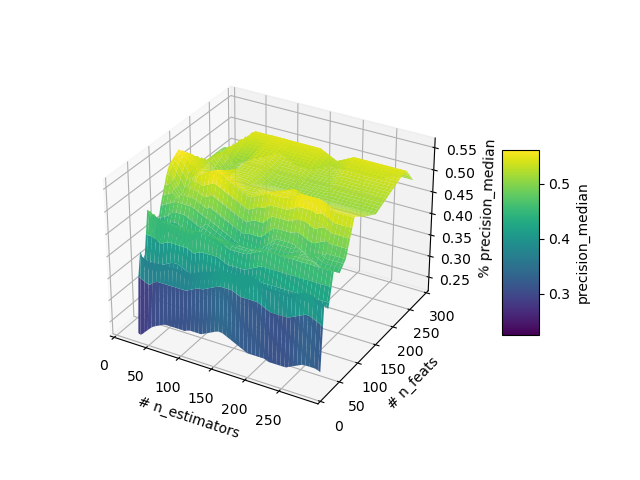

In [41]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'precision_median', y_step=50)

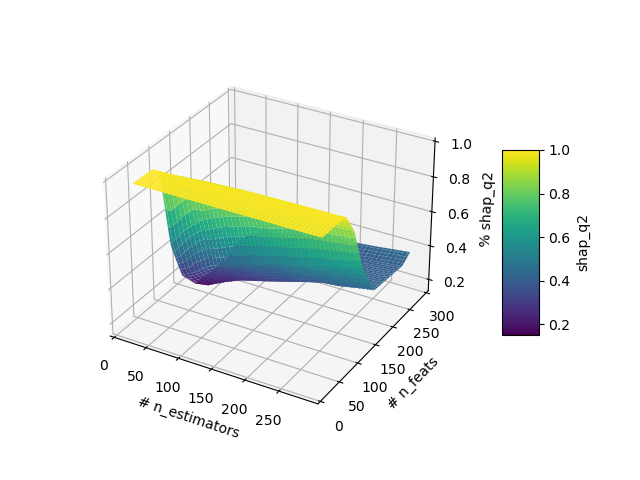

In [42]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'shap_q2', y_step=50)